In [352]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
import pandas as pd
import io #Used as buffer

In [353]:
path= Path(f'../../data/cluster_results')

In [354]:
#freq1nn_w5nn_p3nn_s2nn_tw5nn_bs4nn_epoch3
def read_csv(f):
    df = pd.read_csv(f).mean()
    df['std'] = pd.read_csv(f).std().iloc[0] #remove this line to remove std from table

    df['experiment'] = f.parent.parent.parent.name
    df['function'] = f.parent.parent.name
    name = f.parent.name
    #print(name)
    df['freq'] = int(name[4:].split('n')[0])
    #print(df['freq'])
    df['method'] = f.name.split('_')[0]
    df['nn_p']=name[14:].split('n')[0] 

    return df

measure_name=['mof','sr','arr','nfe','nn_time']
index_measure=0

In [377]:
files[0].parent.name

'freq1nn_w5nn_p5nn_s3nn_tw5nn_bs4nn_epoch3'

In [379]:
m = measure_name[index_measure]

files = list(f for f in path.glob(f'exp*/*/freq1nn_w5nn_p*nn_s3nn_tw5nn_bs4nn_epoch3/*{m}.csv') if 'NNnorm_Worst' in f.name) #path.glob(f'exp*/*/freq1*nn_s*nn_tw*bs*/*{m}.csv')
files=[o for o in files if 'nn_p5' not in o.parent.name]
#print(files)
df = pd.DataFrame([read_csv(f) for f in files])
# data = pd.pivot_table(df, index=['experiment','function'], columns='method', values=m) #,'freq' later for adding frequency experiment
data = pd.pivot_table(df, index=['experiment','function','freq', 'nn_p' ],columns='method' ) #,'freq' later for adding frequency experiment, ,values=m 'ns','tw', 'bs','epochs'
data.style.format("{:,.2f}")


In [380]:
import altair as alt
alt.renderers.enable('notebook')
# DataFrame we use for plots

d = data.reset_index()
d.columns = ['experiment', 'function', 'freq', 'nn_p', 'NNnorm', 'NNnorm_std']
d.head(2)
d1 = d.melt(['experiment','function','freq','nn_p'], value_vars=['NNnorm'],
            var_name='method', value_name='mof')
d2 = d.melt(['experiment','function','freq', 'nn_p'], value_vars=['NNnorm_std'],
            var_name='method', value_name='mof_std')
d2.method = d2.method.str.replace('_std', '')
d = d1.merge(d2)
#d.head()

# Plot functions

In [397]:
def plot_experiment(exp):
    test = d.query(f"experiment=={exp!r}").copy()  # & freq==1"
    mins = test.groupby('function')['mof'].min()
    test['mof_norm'] = test['mof']
    for k,v in mins.iteritems():
        test.loc[test.function==k,'mof_norm'] = test.loc[test.function==k,'mof']/v
    #test.head()

    base = alt.Chart(test)
    chart1 = base.mark_bar().encode(
        alt.X('function', title=''),
        alt.Y('mean(mof_norm)',  title=f'{exp} (mof_norm)'),
        alt.Color('nn_p'),
#         alt.Tooltip(['mof_norm','mof','freq','function']),
    ).properties(
        #title=exp,
        width=300
    )
    return chart1

In [398]:
def plot2_experiment(exp):
    test = d.query(f"experiment=={exp!r}").copy()  # & freq==1"
    mins = test.groupby('function')['mof'].min()
    test['mof_norm'] = test['mof']
    for k,v in mins.iteritems():
        test.loc[test.function==k,'mof_norm'] = test.loc[test.function==k,'mof']/v
    #test.head()

    base = alt.Chart(test)
    chart1 = base.mark_bar().encode(
        alt.X('nn_p', title='', axis=None),
        alt.Y('mean(mof_norm)',  title=f'{exp} (mof_norm)'),
        alt.Color('nn_p',  legend=alt.Legend(title='Selected ind')),
        alt.Column('function', title=''),
        alt.Tooltip(['mof_norm','mof','freq','function']),
    ).properties(
       # title=exp,
        width=50, height=150
    )
    return chart1

In [399]:
def plot3_experiment(exp):
    test = d.query(f"experiment=={exp!r}").copy()  # & freq==1"
    mins = test.groupby('function')['mof'].min()
    test['mof_norm'] = test['mof']
    for k,v in mins.iteritems():
        test.loc[test.function==k,'mof_norm'] = test.loc[test.function==k,'mof']/v
    #test.head()
    base = alt.Chart(test)
    chart1 = base.mark_bar().encode(
        alt.X('nn_p', title='', axis=None),
        alt.Y('mean(mof_norm)',  title=f'{exp} (mof_norm)'),
        alt.Color('nn_p',  legend=alt.Legend(title='Selected ind')),
        alt.Tooltip(['mean(mof_norm)','freq']),
    ).properties(
        #title=exp,
        width=70, height=100
    )
    return chart1

# show plots

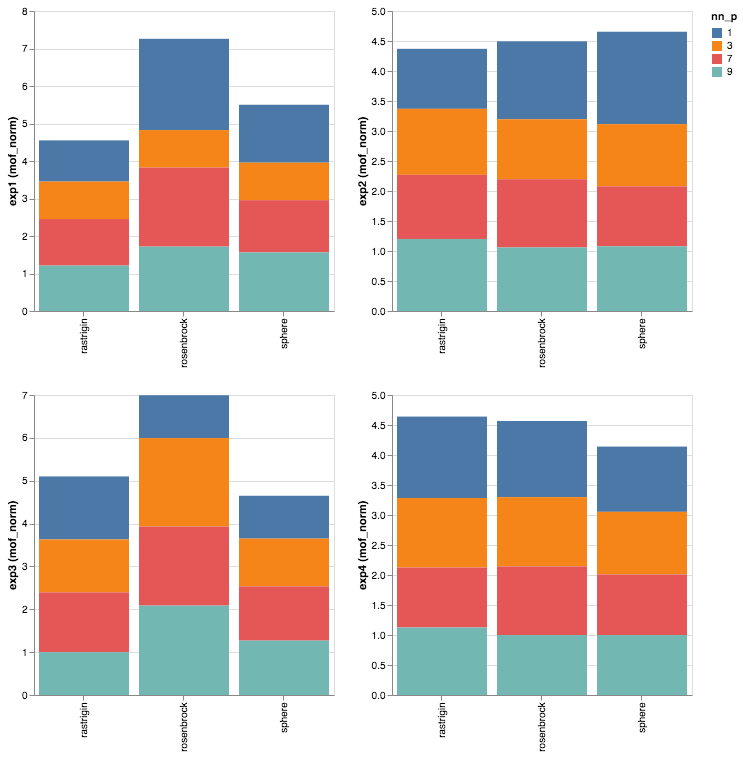

In [400]:
(plot_experiment('exp1')|plot_experiment('exp2'))&(plot_experiment('exp3')|plot_experiment('exp4'))

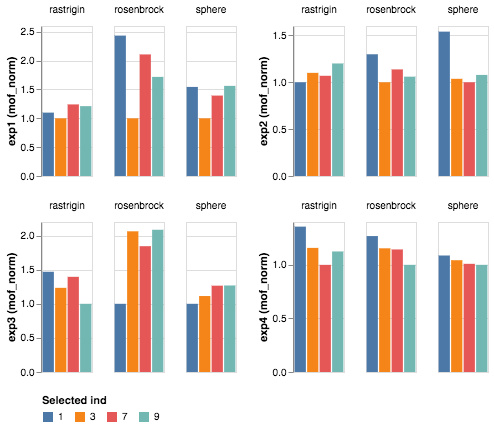

In [404]:
nnpick=(plot2_experiment('exp1')|plot2_experiment('exp2'))&(plot2_experiment('exp3')|plot2_experiment('exp4'))


nnpick = nnpick.configure_legend(
    orient='bottom'
)
nnpick.save(str(path/'nnpick.png'), scale_factor=2)
nnpick


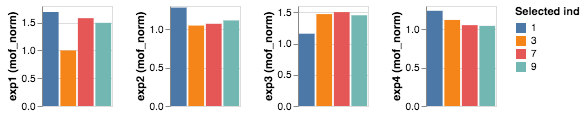

In [402]:
nnpick=(plot3_experiment('exp1')|plot3_experiment('exp2'))|(plot3_experiment('exp3')|plot3_experiment('exp4'))
nnpick

In [403]:
#nnpick.save(str(path/'nnpick.png'), scale_factor=2)